In [1]:
%pip install haversine

  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)
Note: you may need to restart the kernel to use updated packages.


## RoadMap:

1. Determine how to calculate distances between two coordinates given their longitude and latitude.

    The answer to this is the Haversine formula, which has luckily been turned into a Python library.
2. Expand this to work on a full array of coordinates.

    This requires "pairwise" iteration. Pairwise iteration example on a string "ABCDEF" -> AB, BC, CD, DE, DF. Thus, we use pairwise iteration and apply Haversine to form an array that contains the distances between coordinates.

3. Simplify the problem and work with smaller examples that don't have us ending up between points. 

    We must be able to identify the coordinates in this simple case before worrying about what happens when we end up between points. Goal: Construct a coordinate-by-time C in this simple case.

4. Add support to work with "fractional points".

    This refers to finding the difference between points and multiplying by some ratio. This ratio will be the distance traveled between points to the total distance between points. This also includes knowing how to keep a working index in the distances array given that it's entirely possible that there are never nice integer indexes.

5. Add support to first find checkpoints and then identify at what times we will reach them.

6. Determine a correct way to insert 45-minute intervals of 0's in the speed array and theoretical distance array as the algorithm is running! This way, you don't have to keep redoing computations that you already did for the parts of the array that work.

In [2]:
import numpy as np
import itertools as it 
from math import hypot
from haversine import haversine
from matplotlib import pyplot as plt

# Step 1
Determine how to calculate distances between two coordinates given their longitude and latitude.

We're working with Euclidean `(straight-line)` distances for now and using paths defined with Cartesian `(x,y)` coordinates.

We can easily replace this with Haversine `(great-circle)` distances in the future. Euclidean distances just make it easier to reason about. 

In [ ]:
def calculate_distance(p1,p2, print=True):
    """Calculate Euclidean distance between two points."""
    x1,y1 = p1
    x2,y2 = p2
    if print:
      print(f"{p1},{p2}") 
    return round(hypot(x2 - x1, y2 - y1), 2)

# Plot Graph helper method 
def simple_plot_graph(data, title, visible=True):
    """

    Args:
        visible: A control flag specifying if the plot should be shown
        data: A NumPy[n] array of data to plot
        title: The graph title

    Result: Displays a graph of the data using Matplotlib

    """
    fig, ax = plt.subplots()
    x = np.arange(0, len(data))
    ax.plot(x, data)
    plt.title(title)
    if visible:
        plt.show()

In [ ]:
# Step 1 Test:
pt0 = [0, 0]
pt1 = [1, 0]
pt2 = [1, 1]
# These coordinate points, they produce distances with decimals, so need to
# implement calculations that will work with decimals

step1_test_print = False

print(f"Distance between {pt0} and {pt1} = {calculate_distance(pt0, pt1, step1_test_print)}")
print(f"Distance between {pt1} and {pt2} = {calculate_distance(pt1, pt2, step1_test_print)}")
print(f"Distance between {pt0} and {pt2} = {calculate_distance(pt0, pt2, step1_test_print)}")

Distance between [0, 0] and [1, 0] = 1.0
Distance between [1, 0] and [1, 1] = 1.0
Distance between [0, 0] and [1, 1] = 1.41


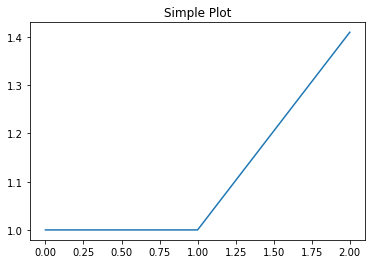

In [ ]:
test_arr = [calculate_distance(pt0, pt1, step1_test_print), calculate_distance(pt1, pt2, step1_test_print), calculate_distance(pt0, pt2, step1_test_print)]

simple_plot_graph(test_arr, "Simple Plot", True)

# Step 2: Pairwise Iteration

To calculate the distances between a full array of coordinates, we need pairwise iteration.

Pairwise Iteration Example on a String "ABCDEF" -> AB, BC, CD, DE, EF.

Luckily, [itertools](https://docs.python.org/3/library/itertools.html#itertools.pairwise) exists and provides a receipe on how to do pairwise iteration.

In [ ]:
example_path = np.array([[0,0], [0,1], [0,2], [0,3], [0,4]])

In [ ]:
# Itertools receipe for pairwise iteration
def pairwise(iterable):
  a, b = it.tee(iterable)
  next(b, None)
  return zip(a, b)

In [ ]:
# for my understanding of what the pairwise function does. And from printing the results of pariwise, it pairs up the points so then you can calculate the distance between the points
def printpair(path):
  for p1, p2 in pairwise(path):
    print(p1, p2)

# Pairwise iteration and prints out the values to see what they are
def pairwiseAndPrint(iterable, show=True):
  a, b = it.tee(iterable)
  next(b, None)
  if show:
    for p1, p2 in zip(a, b):
      print(f"{p1},{p2}")
  return zip(a, b)

#pairwiseAndPrint(example_path, False)

We'll combine this pairwise iteration with Python list comprehension to allow us to calculate distances between coordinates for arrays.

In [ ]:
def calculate_array_distances(path):
  return np.array([calculate_distance(p1, p2, False) for p1, p2 in pairwise(path)])

In [ ]:
# We use list comprehension for this. This is essentially calling the function provided for each pair of arguments we get out of the pairwise iteration 
example_path_distances = calculate_array_distances(example_path)
print(f"{example_path}, \n distances: {example_path_distances}")

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]], 
 distances: [1. 1. 1. 1.]


# Step 3: Simple Example -> Finding Coordinates by Time

We'll consider our distance per second array to be something simple like `[1, 1, 1, 1]`. This means for each of the four seconds, we travel 1 unit in that second.

In [ ]:
step3_distance_per_second = np.array([1,1,1,1])

We'll also define our path to be 3 steps along the y-axis.

In [ ]:
step3_path = np.array([[0,0], [0,1], [0,2], [0,3]])

Use Step 2's work to find distance between path.

In [ ]:
step3_path_distances = calculate_array_distances(step3_path)
print(f"{step3_path} distances: {step3_path_distances}")

[[0 0]
 [0 1]
 [0 2]
 [0 3]] distances: [1. 1. 1.]


In [ ]:
def step3_match_coords(path, path_distances, distance_per_second):
  path_distance_index = 0

  coordinate_by_time = []

  # Use Enumeration, which allows us to use both the iteration number and value while iterating
  # Ex: Iteration 0: i = 0, distance
  # for i, value in enumerate(array) i = 0, 1, 2, value = array[0], array[1]...

  for i, distance in enumerate(distance_per_second):
    print(f"Travelled {distance} m at second {i}")
    
    # If I travelled a distance equal to the next point, I'll add it to the list.
    if path_distances[path_distance_index] == dist:
      # Then, I'll add it to the list of coordinates
      coordinate_by_time.append(path[path_distance_index])
      # Increment the path distance to show I reached that coordinate and ready
      # to analyze the next segment
      path_distance_index += 1

      # Exit if path_distance_index goes out of bounds. Means we reached end of path.
      if(path_distance_index >= len(path_distances)): 
        return np.array(coordinate_by_time)
  
  return np.array(coordinate_by_time) 

In [ ]:
step3_coord_by_time = step3_match_coords(path=step3_path, path_distances=step3_path_distances, distance_per_second=step3_distance_per_second)

print(step3_coord_by_time)

Travelled 1 m at second 0
Travelled 1 m at second 1
Travelled 1 m at second 2
[[0 0]
 [0 1]
 [0 2]]


In [ ]:
print("asdfasfasfd")